Rainfall weather generators are tools designed to simulate realistic precipitation events based on statistical properties of historical actual rainfall data. These generators often rely on probability distributions to model the frequency, intensity, and duration of rain events within a specific region. By fitting historical rainfall patterns to known statistical distributions, such as the Poisson distribution for occurrence and the Gamma or Log-Normal distributions for rainfall amounts, weather generators can create synthetic rainfall series that mimic the natural variability observed in real-world precipitation records. 

Rainfall generators are useful in agricultural and hydrological modeling by providing a way to generate plausible rainfall scenarios to assist researchers and practitioners in planning and decision-making processes, particularly in contexts where understanding the variability and extremes of rainfall is essential.


In [29]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma
from scipy.optimize import curve_fit


## Read and inspect dataset

In [30]:
# Load sample data
df = pd.read_csv("../datasets/KS_Manhattan_6_SSW.csv",
                 na_values=[-9999], parse_dates=['LST_DATE'], date_format='%Y%m%d')

# Inspect a few rows
df.head(3)


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,2003-10-01,1.201,-96.61,39.1,NaN,NaN,NaN,NaN,NaN,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
1,53974,2003-10-02,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
2,53974,2003-10-03,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN


In [31]:
# Add year, month, and day of the year to summarize data in future steps.
df["YEAR"] = df["LST_DATE"].dt.year
df["MONTH"] = df["LST_DATE"].dt.month
df["DOY"] = df["LST_DATE"].dt.dayofyear
df.head(3)


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY,YEAR,MONTH,DOY
0,53974,2003-10-01,1.201,-96.61,39.1,NaN,NaN,NaN,NaN,NaN,...,-99,-99,NaN,NaN,NaN,NaN,NaN,2003,10,274
1,53974,2003-10-02,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,-99,-99,NaN,NaN,NaN,NaN,NaN,2003,10,275
2,53974,2003-10-03,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,-99,-99,NaN,NaN,NaN,NaN,NaN,2003,10,276


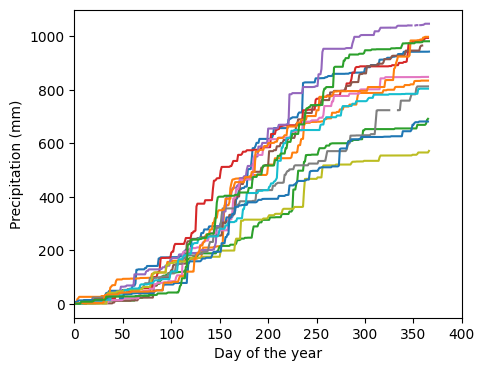

In [33]:
# Observe trends in precipitation data (2004 to 2016)
plt.figure(figsize=(5,4))
plt.xlim(0,400)
plt.xlabel('Day of the year')
plt.ylabel('Precipitation (mm)')
for year in range(2004,2017):
    idx_year = df["YEAR"] == year
    P_cum = df["P_DAILY_CALC"][idx_year].cumsum()
    plt.plot(range(1,len(P_cum)+1), P_cum)
    

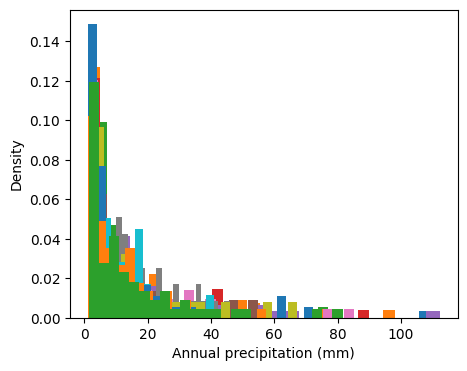

In [34]:
# Observe histograms of precipitation

plt.figure(figsize=(5,4))
plt.xlabel('Annual precipitation (mm)')
plt.ylabel('Density')
for year in range(2004,2017):
    idx_year = df["YEAR"] == year
    rainfall_year = df["P_DAILY_CALC"][idx_year]
    rainfall_year = rainfall_year[rainfall_year > 1]
    plt.hist(rainfall_year, bins=25, density=True)


## Modeling rainfall as a Markov chain. 

This type of rainfall generators is kwnon as the Richardson-type models (Richardson and Wright, 1984). The model computes the rainfall at time `t` as a function of time `t-1` in three steps. To be consistent with the original manuscript by Richardson and Wright (1984), we will use the term "wet" for a day with measurable rainfall and "dry" for a day without measurable rainfall.

**Step 1**: Find if the previous day was dry or wet

**Step 2**: Compute the probability of having a rainfall event on day `t` given the condition on the previous day. So, here we need to have two different probability distributions, one that we will use if yesterday was dry and another if yesterday was wet. 

- What is the probability of having a wet day if yesterday was dry? (i.e. P(W/D) )

- What is the probability of having a wet day if yesterday was wet? (i.e. P(W/W) )

To accurately simulate seasonal rainfall trends, the model relies on Wet-Dry and Wet-Wet distributions on a monthly basis.

Steps 1 and 2 deal with the probability of rainfall occurrence, not the amount of rainfall. The next step will help us determine the amout of rainfall on wet days.

**Step 3**: If as a consequence of the random process we obtain that on day `t` there is a rainfall event (i.e., day `t` is a `wet` day), then we have to compute the amount. To do this we will use a gamma distribution, which is suited to heavily skewed distributions, such as those resulting from histograms of daily rainfall (see previous histogram figure). To complete this step were need to have some parameters that describe this rainfall amount distribution on a monthly basis. These parameters are often determined by fitting the gamma distribution to historical rainfall data.


We will first run an example using the loaded dataset to learn how to compute the Wet-Dry and Wet-Wet probabilities for the entire year. It's important that we first learn how to compute the simplest step before moving into a more detailed characterization of the rainfall process on a monthly basis.


## Determine probability of rainfall occurrence by month

The first step of this process is to characterize the probability functions using observed data.

#### Probability of Wet-Dry and Wet-Wet days

In [47]:
# Initialize empty arrays
WW = []
WD = []
month_WW = []
month_WD = []

# Create shorter variable names
months = df["MONTH"].values
rainfall = df["P_DAILY_CALC"].values

for i in range(1,df.shape[0]):
    
    # Determine if yesterday was Wet or Dry
    # Append "1" if today was Wet, else append "0"
    if rainfall[i-1] > 0:
        
        month_WW.append(months[i])
        if rainfall[i] > 0:
            WW.append(1)
        else:
            WW.append(0)
    
    elif rainfall[i-1] == 0:
        
        month_WD.append(months[i])
        if rainfall[i] > 0:
            WD.append(1)
        else:
            WD.append(0)

print(sum(WW)/len(WW))
print(sum(WD)/len(WD))


0.4166666666666667
0.20590604026845638


#### Create table with probabilities by month

In [48]:
# Wet/Wet table
df_WW = pd.DataFrame({'month':month_WW, 'WW':WW})

# Wet/Dry
df_WD = pd.DataFrame({'month':month_WD, 'WD':WD})

# Compute monthly probabilities per month
monthly_WW = df_WW.groupby("month").sum() / df_WW.groupby("month").count()
monthly_WD = df_WD.groupby("month").sum() / df_WD.groupby("month").count()

# Create single table of parameters
coeff = pd.concat([monthly_WW, monthly_WD], axis=1)
coeff

,WW,WD
month,,
1,0.338028,0.141176
2,0.320513,0.161184
3,0.401709,0.219048
4,0.503448,0.273063
5,0.480769,0.290909
6,0.442953,0.293680
7,0.415254,0.228571
8,0.412214,0.245847
9,0.362745,0.201258


## Determine probability of daily rainfall amount

In [49]:
# Fit gamma distribution to each month
monthly_shape = []
monthly_scale = []

for m in range(1,13):
    idx_month = df["MONTH"] == m
    x = df["P_DAILY_CALC"].loc[idx_month]
    x = x[~np.isnan(x)] # Save only non NAN values
    x = x[x>0] # Save only positive rainfall values
    shape, loc, scale = gamma.fit(x, floc=0)
    monthly_shape.append(shape)
    monthly_scale.append(scale)

# Append amount parameters to monthly lookup table
coeff["shape"] = monthly_shape
coeff["scale"] = monthly_scale
coeff.head(12)


,WW,WD,shape,scale
month,,,,
1,0.338028,0.141176,0.748257,4.166760
2,0.320513,0.161184,0.678656,8.142081
3,0.401709,0.219048,0.632519,11.092325
4,0.503448,0.273063,0.589697,15.483557
5,0.480769,0.290909,0.630033,13.661336
6,0.442953,0.293680,0.599585,22.291664
7,0.415254,0.228571,0.677182,16.648971
8,0.412214,0.245847,0.625811,21.885339
9,0.362745,0.201258,0.585308,15.593047


Check that our gamma function can generate sound rainfall distributions. Note that the figure below is the probability density function (pdf), not the actual rainfall amount. The y-axis contains density information while the x-axis contains rainfall data.

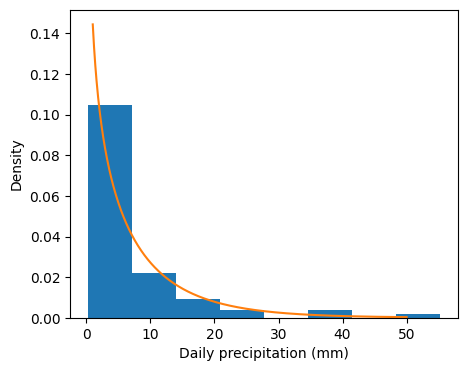

In [50]:
# Show frequency of rainfall amount for last month of the fitting
a,b,c = gamma.fit(x, floc=0)

plt.figure(figsize=(5,4))
plt.hist(x, bins='scott', density=True)
rainfall_range = np.linspace(1, 50, 1000)
plt.plot(rainfall_range, gamma.pdf(rainfall_range,a,b,c))
plt.xlabel('Daily precipitation (mm)')
plt.ylabel('Density')
plt.show()


## Build rainfall generator

Now that we have all the distribution properties we can implement the rainfall generator.

In [51]:
# Define rainfall simulator
def rainfall_gen(dates,coeff):
    
    P = np.ones(dates.shape[0])*np.nan
    P[0] = 0

    for t in range(1,dates.shape[0]):
        month = dates.month[t]
        if P[t-1] == 0:
            if np.random.rand() > coeff["WD"][month]:
                P[t] = 0
            else:
                P[t] = gamma.rvs(coeff["shape"][month],0,coeff["scale"][month])
                P[t] = np.round(P[t]*10)/10

        elif P[t-1] > 0:
            if np.random.rand() > coeff["WW"][month]:
                P[t] = 0
            else:
                P[t] = gamma.rvs(coeff["shape"][month],0,coeff["scale"][month])
                P[t] = np.round(P[t]*10)/10

    P_total = P.sum()
    return P


## Create rainfall scenarios with the generator

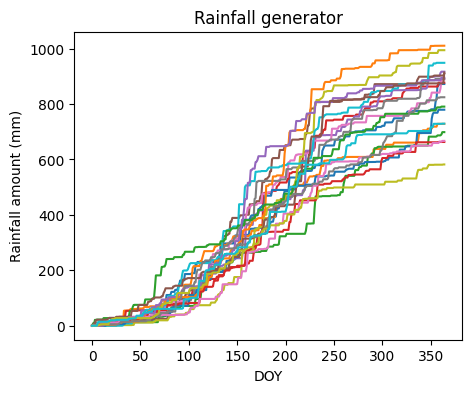

In [52]:
# Create an example set of dates
dates = pd.date_range("2018-01-01","2018-12-31",freq="D")

# Call rainfall generator multiple times and plot cumulative rainfall
plt.figure(figsize=(5,4))
for i in range(20):
    P = rainfall_gen(dates,coeff)
    plt.plot(P.cumsum())
    
plt.title("Rainfall generator")
plt.xlabel("DOY")
plt.ylabel("Rainfall amount (mm)")
plt.show()


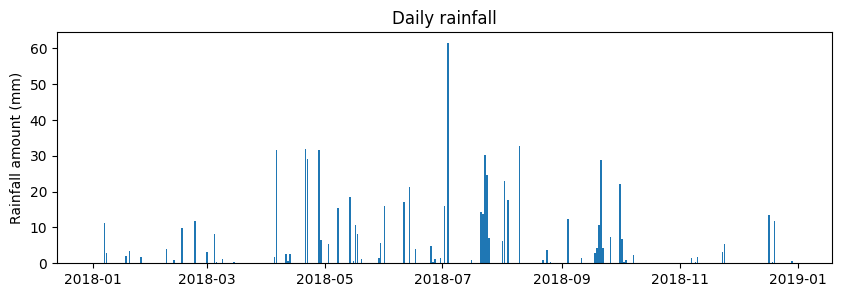

In [53]:
# Plot the last iteration
plt.figure(figsize=(10,3))
plt.bar(dates,P)
plt.title("Daily rainfall") # for last year of the previous simulation
plt.ylabel("Rainfall amount (mm)")
plt.show()


## References

Intergernmental Panel on Climate Change Data Distribution Centre: https://www.ipcc-data.org/guidelines/pages/weather_generators.html

Jones, P., Harpham, C., Kilsby, C., Glenis, V. and Burton, A., 2010. UK Climate Projections science report: Projections of future daily climate for the UK from the Weather Generator.

Kilsby, C.G., Jones, P.D., Burton, A., Ford, A.C., Fowler, H.J., Harpham, C., James, P., Smith, A. and Wilby, R.L., 2007. A daily weather generator for use in climate change studies. Environmental Modelling & Software, 22(12), pp.1705-1719.

Richardson, C.W., 1982. Dependence structure of daily temperature and solar radiation. Transactions of the ASAE, 25(3), pp.735-0739.

Richardson, C.W. and Wright, D.A., 1984. WGEN: A model for generating daily weather variables.